# Training U-Net convolutional network for image segmentation

## Acknowledgements

Parts of this code are derived from [DeLTA](https://delta.readthedocs.io/en/latest/index.html) - in particular the data augmentation and implementation of the pixelwise weighted loss.

## Work flow
1. Generate training data (can be done using the Annotate widget in napari-MM3).


2. Import our images.
    * The images are put into a generator so they are not loaded all at the same time. 
    * The generator will "augment" the images for training, that is, it will transform them in a number of ways to artificially increase the pool of training data to draw from. 
    * The image dimensions must be powers of two, based on how they are convolved. 
    
    
3. Build the model.
    * Set up the convolution, ReLU, max pooling, and other operations that dictate how our images are modified. 
    * The number of layers in the network is dictated by the image size. 
    * We also define custom loss functions. The loss function is a measure of how different the predicted labels are from the actual labels. Training means iteratively improving the model to minimize the loss.  
    
    
4. Train the model.
    * This step takes awhile. 
    * We will output a graph that plots the loss over training steps.

In [1]:
import os
import sys
import glob
from pathlib import Path

import numpy as np
import itertools
from scipy import ndimage as ndi  # use for binary_fill_holes
from scipy import interpolate
import skimage.transform as trans
from skimage import morphology as morph  # use for remove small objects
from skimage.filters import gaussian
from skimage import io
import tifffile as tiff
from pprint import pprint
import elasticdeform
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Union, List, Tuple, Iterator, Any
import numpy.typing as npt

# learning modules
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import models, losses
from tensorflow.python.ops import array_ops, math_ops
from keras.models import Model
from keras.layers import (
    Input,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Dropout,
    UpSampling2D,
    Concatenate,
    BatchNormalization,
    Activation
)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

2023-05-16 14:16:51.840070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## modify this for the location of the helpers file on your computer
# helpers_folder = os.path.realpath('path_to_helpers')

# if helpers_folder not in sys.path:
#     sys.path.insert(0, helpers_folder)
    
import unet_helpers as mm3

### Parameters

In [3]:
## location of the raw images for training
image_dir = Path('/Volumes/JunLabSSD_03/unet_training/images/')
## location of the training masks
mask_dir = Path('/Volumes/JunLabSSD_03/unet_training/masks/')
## location of weights (will be created automatically if not already existing)
weights_dir = Path('/Volumes/JunLabSSD_03/unet_training/weights_new/')
## size to rescale images
target_size_seg = (256,32)
## path to save trainined model to
savefile = Path('/Volumes/JunLabSSD_03/unet_training/20230516_mm3_256x32_64_1.hdf5')
## fraction of data to be used for training / validation
validation_split = .9
## batch size - should be power of 2
batch_size=4
### number of epochs to train for
epochs=300
## stop after this many epochs without decreased validation loss (early stopping)
patience=50
## Location of existing model, if you want to re-train
pretrained_weights = None

### Make weightmaps if needed

In [8]:
mask_files = glob.glob(os.path.join(mask_dir, "*.tif"))
mask_names = [name.split("/")[-1] for name in mask_files]

if not weights_dir.exists():
    weights_dir.mkdir()

In [9]:
for (mask_file, mask_name) in zip(mask_files, mask_names):

    with tiff.TiffFile(mask_file) as tif:
        mask = tif.asarray()

    weightmap = mm3.seg_weights_2D(mask)

    tiff.imwrite(weights_dir / mask_name, weightmap)

### Generators for training and validation sets

In [4]:
# Data generator parameters:
data_gen_args = dict(
    rotation=2,
    rotations_90d=True,
    zoom=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    histogram_voodoo=True,
    illumination_voodoo=True,
    gaussian_noise=0.03,
    gaussian_blur=1,
)

# Get training image files list:
image_name_arr = glob.glob(str(image_dir / "*.png")) + glob.glob(
    str(image_dir / "*.tif")
)

# randomize and split between training and test
np.random.shuffle(image_name_arr)

training_n = int(len(image_name_arr) * validation_split)
training_set = image_name_arr[:training_n]
validation_set = image_name_arr[training_n:]

print(f"Training set has {len(training_set)} images")
print(f"Validation set has {len(validation_set)} images")

# Training data generator:
train_generator = mm3.trainGenerator(
    training_set,
    batch_size,
    mask_dir,
    weights_dir,
    augment_params=data_gen_args,
    target_size=target_size_seg,
)

# Validation data generator:
val_generator = mm3.trainGenerator(
    validation_set,
    batch_size,
    mask_dir,
    weights_dir,
    augment_params=data_gen_args,
    target_size=target_size_seg,
)

Training set has 448 images
Validation set has 50 images


### Initialize the model

In [5]:
model = mm3.unet((256,32,1),num_filters=64)

loss = mm3.pixelwise_weighted_bce
metrics = [mm3.binary_acc]

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss,
    metrics=metrics,
)

if pretrained_weights:
    model.load_weights(pretrained_weights)
    
# inspect:
model.summary()

2023-05-16 14:17:15.915194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 14:17:15.916180: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-16 14:17:15.916221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 14:17:15.916561: I tensorflow/core/

Metal device set to: AMD Radeon Pro 5500 XT
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 256, 32, 64)  640         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 32, 64)  36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 16, 64

In [6]:
# Callbacks:
model_checkpoint = ModelCheckpoint(
    savefile, monitor="val_loss", verbose=2, save_best_only=True
)
early_stopping = EarlyStopping(
    monitor="val_loss", mode="min", verbose=2, patience=patience
)

steps_per_epoch_train = int(np.ceil(len(training_set) / float(batch_size)))
steps_per_epoch_val = int(np.ceil(len(validation_set) / float(batch_size)))

### Train

In [7]:
# Train:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs,
    callbacks=[model_checkpoint, early_stopping],
    validation_data=val_generator,
    validation_steps=steps_per_epoch_val,
)

Epoch 1/300


2023-05-16 14:17:25.110264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


112/112 [==============================] - ETA: 0s - loss: 576.0028 - binary_acc: 0.9308

2023-05-16 14:17:51.594399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 512.87878, saving model to /Volumes/JunLabSSD_03/unet_training/20230516_mm3_256x32_64_1.hdf5
112/112 [==============================] - 37s 308ms/step - loss: 576.0028 - binary_acc: 0.9308 - val_loss: 512.8788 - val_binary_acc: 0.9238
Epoch 2/300
112/112 [==============================] - ETA: 0s - loss: 459.4615 - binary_acc: 0.9397
Epoch 2: val_loss improved from 512.87878 to 431.43073, saving model to /Volumes/JunLabSSD_03/unet_training/20230516_mm3_256x32_64_1.hdf5
112/112 [==============================] - 33s 294ms/step - loss: 459.4615 - binary_acc: 0.9397 - val_loss: 431.4307 - val_binary_acc: 0.9352
Epoch 3/300
112/112 [==============================] - ETA: 0s - loss: 393.8430 - binary_acc: 0.9461
Epoch 3: val_loss improved from 431.43073 to 342.61493, saving model to /Volumes/JunLabSSD_03/unet_training/20230516_mm3_256x32_64_1.hdf5
112/112 [==============================] - 27s 242ms/step - loss: 393.8430 - binary_acc: 0.9461 - val_los

### Visualize results

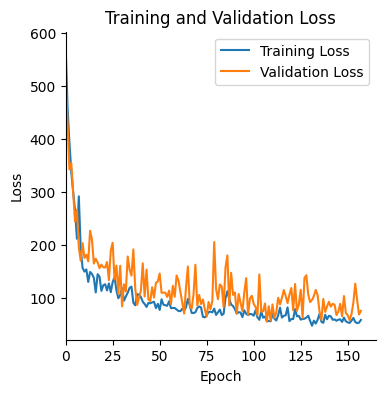

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = history.epoch

plt.figure(figsize=(4, 4))

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, None)
sns.despine()

In [11]:
test_dir = '/Volumes/JunLabSSD_03/unet_training/test/'

In [82]:
## can also load another model here to compare

# model = keras.models.load_model('/Volumes/JunLabSSD_03/unet_training/20230515_unet_256x32_px_weighted_64.hdf5',
#                                custom_objects = {
#                 "binary_acc": mm3.binary_acc,
#                 "pixelwise_weighted_bce": mm3.pixelwise_weighted_bce,
#             })

In [84]:
predict_gen, predict_gen_v = itertools.tee(mm3.predictGenerator(test_dir))

In [85]:
predictions = model.predict(predict_gen)

2023-05-16 15:59:59.002103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 26ms/step


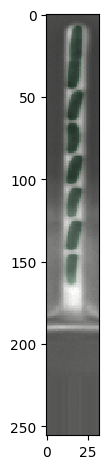

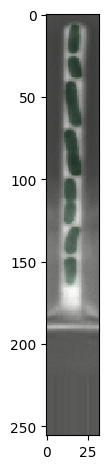

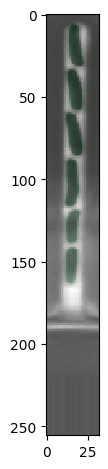

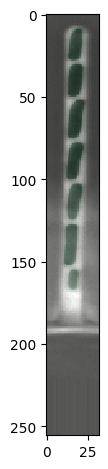

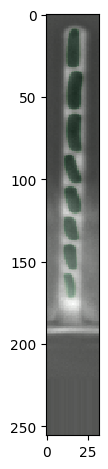

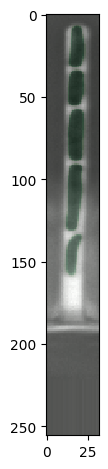

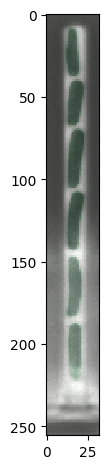

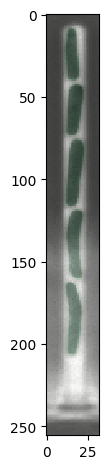

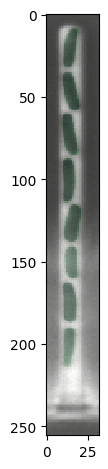

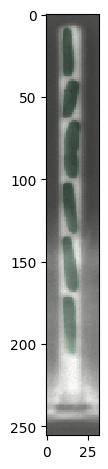

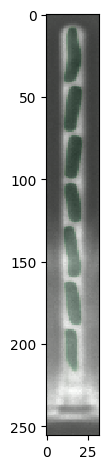

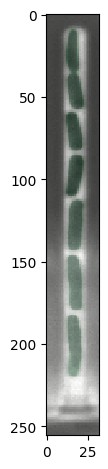

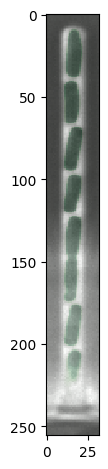

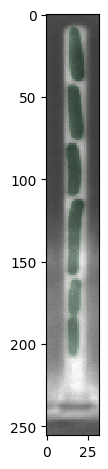

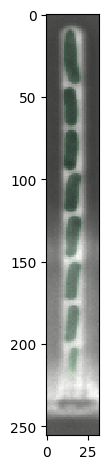

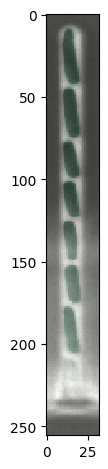

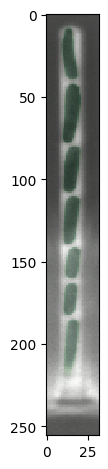

In [87]:
for i, p in enumerate(predictions):
    plt.figure()
    img = next(predict_gen_v)
    # io.imshow(p)
    io.imshow(img[0,:,:])
    io.imshow(p,alpha=.25,cmap=plt.cm.Greens)